In [1]:
## Import functions

import numpy as np  
import pandas as pd
np.set_printoptions(suppress=True) # Supress scientific notation when printing
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import re # Regular expressions
import networkx as nx # Package for graph represenations 
from datetime import datetime, time 
import pygraphviz as gv

from networkx.drawing.nx_agraph import graphviz_layout, to_agraph, write_dot
from scipy.ndimage.filters import uniform_filter1d


from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.signal import argrelextrema
from scipy import signal

In [2]:
edgelist_filename = '../data/graph_edgelist.dat'

### load graph
print("load graph")
G = nx.read_edgelist(edgelist_filename)  
print("graph: number of nodes = ",G.number_of_nodes(),", edges = ",G.number_of_edges())

### pre-compute all possible shortest path lengths and save in dictionary (does not save shortest paths itself)
DD = nx.shortest_path_length(G) 
DD = dict(DD)
print("dictionary: len =", len(DD), ", total items =", sum([len(dv) for dv in DD.values()]))

# get node positions from recosntructed graph 
pos = graphviz_layout(G)

load graph
graph: number of nodes =  96 , edges =  125
dictionary: len = 96 , total items = 9216


In [3]:
## Set file names and paths

# Read full processed csv file and select rat and session

# SET CORRECT FILENAME!!!!!!!, since import date may differ!!!
filename = '../results/Rat_HM_Ephys_AggProc_20220202.csv'

data_full = pd.read_csv(filename)

In [4]:
from __future__ import division 

def interpolated_intercept(x, y1, y2):
    """Find the intercept of two curves, given by the same x data"""

    def intercept(point1, point2, point3, point4):
        """find the intersection between two lines
        the first line is defined by the line between point1 and point2
        the second line is defined by the line between point3 and point4
        each point is an (x,y) tuple.

        So, for example, you can find the intersection between
        intercept((0,0), (1,1), (0,1), (1,0)) = (0.5, 0.5)

        Returns: the intercept, in (x,y) format
        """    

        def line(p1, p2):
            A = (p1[1] - p2[1])
            B = (p2[0] - p1[0])
            C = (p1[0]*p2[1] - p2[0]*p1[1])
            return A, B, -C

        def intersection(L1, L2):
            D  = L1[0] * L2[1] - L1[1] * L2[0]
            Dx = L1[2] * L2[1] - L1[1] * L2[2]
            Dy = L1[0] * L2[2] - L1[2] * L2[0]

            x = Dx / D
            y = Dy / D
            return x,y
        L1 = line([point1[0],point1[1]], [point2[0],point2[1]])
        L2 = line([point3[0],point3[1]], [point4[0],point4[1]])

        R = intersection(L1, L2)

        return R

    idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)
    xc, yc = intercept((x[idx], y1[idx]),((x[idx+1], y1[idx+1])), ((x[idx], y2[idx])), ((x[idx+1], y2[idx+1])))
    return xc.flatten(),yc.flatten()

   
# #For the model with 3 Gaussians
# x_ax  = f_axis1
# y1 = c[0]
# y2 = c[2]

# plt.plot(x_ax, y1, marker='o', mec='none', ms=4, lw=1, label='y1')
# plt.plot(x_ax, y2, marker='o', mec='none', ms=4, lw=1, label='y2')

# idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)

# plt.plot(x_ax[idx], y1[idx], 'ms', ms=7, label='Nearest data-point method')

# # new method!
# xc, yc = interpolated_intercept(x_ax,y1,y2)
# plt.plot(xc, yc, 'co', ms=5, label='Nearest data-point, with linear interpolation')
# print(xc,yc)


# plt.legend(frameon=False, fontsize=10, numpoints=1, loc='lower left')

# plt.show()

In [5]:
def intersectionPoint(ratNr):
    
    dataRatNr = data_full.loc[data_full['rat_no']==ratNr]
    dates = dataRatNr['date'].unique()
    meanIntersection = list()
    mean1 = list()
    mean2 = list()
    intersectionPoint = list()
    
    for i in dates:
        dataRatSession = data_full.loc[(data_full['rat_no']==ratNr) & (data_full['date']==i)]
        sp = dataRatSession['speed_ff']*-1

        sptotal = pd.concat([dataRatSession['speed_ff'],(sp)])

        gmm2 = GaussianMixture(n_components = 3).fit(np.asarray(sptotal).reshape(-1, 1))
        
        #plt.figure()
        #plt.hist(sptotal, bins=np.linspace(-1,1,50), histtype='stepfilled', density = True, alpha=0.5)
        #plt.xlim(-1, 1)
        
        f_axis1 = sptotal.copy().ravel()
        f_axis1.sort()
        a = []
        c = []
        for weight, mean, covar in zip(gmm2.weights_, gmm2.means_, gmm2.covariances_):
            a.append(mean)
            c.append(weight*norm.pdf(f_axis1, mean, np.sqrt(covar)).ravel())
            #plt.plot(f_axis1, c[-1])
            
        #plt.plot(f_axis1, np.array(c).sum(axis =0), 'k-')
        #plt.xlabel('Variable')
        #plt.ylabel('PDF')
        #plt.tight_layout()
        #plt.show()
        a=np.asarray(a)
        
        g1=np.argmin(abs(a))
        g2=np.argmax(a)

        a = (a[g1],a[g2])
        c = (c[g1],c[g2])
        
        x_axis  = f_axis1
        y1 = c[0]
        y2 = c[1]
        #plt.plot(x_axis, y1, marker='o', mec='none', ms=4, lw=1, label='y1')
        #plt.plot(x_axis, y2, marker='o', mec='none', ms=4, lw=1, label='y2')
        idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)
       

        #plt.plot(x_axis[idx], y1[idx], 'ms', ms=7, label='Nearest data-point method')
        y1 = y1[x_axis>0]
        y2 = y2[x_axis>0]
        x_axis = x_axis[x_axis>0]
        xc, yc = interpolated_intercept(x_axis,y1,y2)
        #plt.plot(xc, yc, 'co', ms=5, label='Nearest data-point, with linear interpolation')
        mean1.append(a[0])
        mean2.append(a[1])
        intersectionPoint.append((xc,yc))
        meanIntersection.append((a[0].flatten(),(xc.flatten(),yc.flatten()), a[1].flatten()))
    return mean1 , mean2, intersectionPoint, dates, dataRatNr
#mean1,mean2,intersectionP, dateD, dataRatNr = intersectionPoint('Rat5')
#print(intersectionPoint('Rat5'))

# Plotting in time the averages of the intersection point and means per session.
# Calculating the intersection point of average point within trials (min aantal puntnen?)

In [74]:
def getnewDataframe (dataR, sessionNumber, ratNr, intersection_point):
    
    listAtWhatSpeedCrossesLine = list()
    listSpeed = list()
    listTimes = list()
    indexList = list()
    goalNodeList = list()
    trialNumberList = list()
    intersectionNodeList = list()
    listSessionNumber = list()
    dates = dataR['date'].unique()
    if sessionNumber==0:
        for n_sess,z in enumerate(dates):
            print(intersection_point[n_sess][0])
            dataRatSession = data_full.loc[(data_full['rat_no']==ratNr) & (data_full['date']==z)]
            dataRatSession.set_index('trial_no', inplace=True)
            tr_list = dataRatSession.index.unique()
            for tr in tr_list:
                q = 0
                p = 0
                b = dataRatSession.loc[tr, 'speed_ff']
                i = -1
                for j in b:
                        
                        if(j<=i and j>=intersection_point[n_sess][0]):
                            listAtWhatSpeedCrossesLine.append((tr, j))
                            if q==0:
                                trialNumberList.append(tr)
                                listSpeed.append((tr,j))
                                listTimes.append(dataRatSession.loc[tr,'cum_seconds'].iloc[p])
                                indexList.append(p)
                                goalNodeList.append(dataRatSession.loc[tr,'node'].iloc[-1])
                                intersectionNodeList.append(dataRatSession.loc[tr,'node'].iloc[p]) 
                                listSessionNumber.append(z)
                            q+=1   
                        i=j
                        p+=1

    else:
        dataRatSession = data_full.loc[(data_full['rat_no']==ratNr) & (data_full['date']==sessionNumber)]
        dataRatSession.set_index('trial_no', inplace=True)
        tr_list = dataRatSession.index.unique()
        
        n_sess = np.argwhere(sessionNumber)[0][0] # Was: n_sess = np.argwhere(session_number == sessionNumber)[0][0] 
        print(intersection_point[n_sess][0])
        for tr in tr_list:
            q = 0
            p = 0
            b = dataRatSession.loc[tr,'speed_ff']
            i = -1
            for j in b:
                    if(j<=i and j>=intersection_point[n_sess][0]):
                        listAtWhatSpeedCrossesLine.append((tr, j))
                        if q==0:
                            trialNumberList.append(tr)
                            listSpeed.append((tr,j))
                            listTimes.append(dataRatSession.loc[tr,'cum_seconds'].iloc[p])
                            indexList.append(p)
                            goalNodeList.append(dataRatSession.loc[tr,'node'].iloc[-1])
                            intersectionNodeList.append(dataRatSession.loc[tr,'node'].iloc[p]) 
                            listSessionNumber.append(sessionNumber)
                        q+=1   
                    i=j
                    p+=1
                    
    res = pd.DataFrame(list(zip(trialNumberList, listTimes, indexList, intersectionNodeList, goalNodeList,listSessionNumber)),
               columns =['trial_number', 'time', 'index', 'intersection_node', 'goal_node','session_number'])
    res.sort_values(by = ['session_number', 'trial_number'], ascending=[True,True], inplace = True)
    res.drop_duplicates(subset=['session_number','trial_number'],keep=False, inplace = True)
    return res

In [75]:
def getInfoRat(ratNr, sessionNr):
    mean1,mean2,intersection_point, session_number, dataRatNr = intersectionPoint(ratNr)
    df = getnewDataframe(dataRatNr, sessionNr, ratNr, intersection_point)
    cf = df.copy()
    cf = cf.groupby(['goal_node', 'intersection_node'])['intersection_node'].count().reset_index(
  name='Count').sort_values(['Count'], ascending=False)
    #print(cf)
    return df, cf

In [80]:
dataFram, dictF = getInfoRat('Rat5', 0)
#print(dataFram)
#print(dictF)

[0.16087066]
[0.17783625]
[0.16338227]
[0.15690199]
[0.18747182]
[0.14360431]


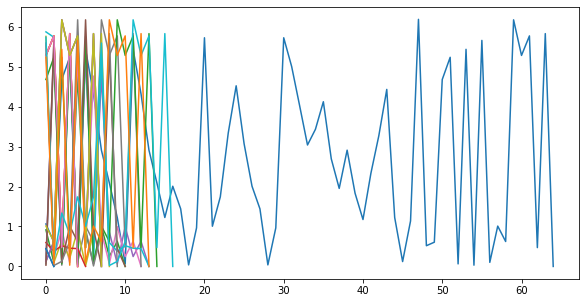

In [78]:
# COMPUTE ANGLE TOWARDS GOAL


for tr in range(dataFram.shape[0]):
    
    tr_n = dataFram.loc[tr]['trial_number']
    se_n = dataFram.loc[tr]['session_number']
    ra_n = 'Rat5'

    idx = dataFram.loc[tr]['index']
    goal = dataFram.loc[tr]['goal_node']

    data_trial = data_full[(data_full['rat_no']==ra_n) & (data_full['date']==se_n) & (data_full['trial_no']==tr_n)]
    node_list = np.asarray(data_trial['node'][idx:]) 



    dir_angle = np.zeros(len(node_list)-1)
    for k,no in enumerate(node_list[:-1]):

        g_pos = pos[str(goal)]

        vertex = pos[str(node_list[k])]

        n_pos = pos[str(node_list[k+1])]

        dir_angle[k] = np.abs(np.arctan2(g_pos[1] - vertex[1], g_pos[0] - vertex[0]) - np.arctan2(n_pos[1] - vertex[1], n_pos[0] - vertex[0]));
    plt.plot(dir_angle)

here
{118: [104, 4], 109: [104, 2], 207: [104, 2], 301: [104, 1], 324: [104, 1], 318: [104, 1], 317: [104, 1], 308: [104, 1], 303: [104, 1], 223: [104, 1], 224: [104, 1], 218: [104, 1], 215: [104, 1], 210: [104, 1], 202: [104, 1], 120: [104, 1], 403: [104, 1]}


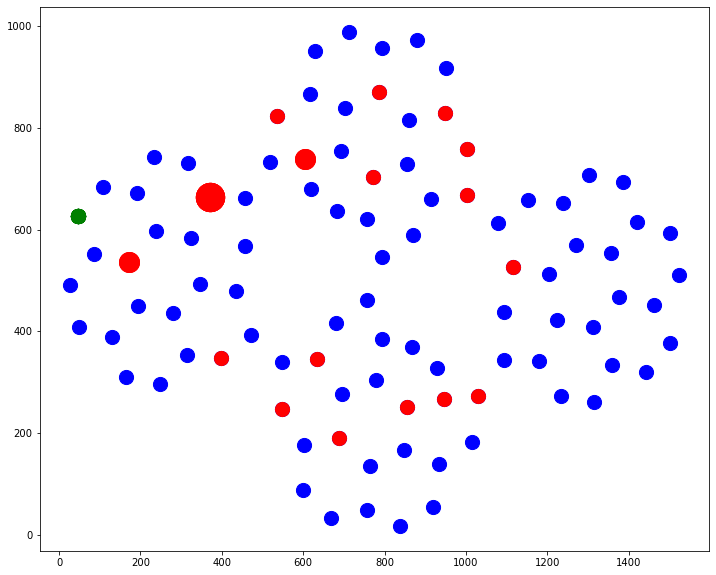

In [79]:
v=0
dictFtry = dictF.set_index('intersection_node').T.to_dict('list')

for i in (dataFram['goal_node'].unique()):
    d_subset = {key: value for key, value in dictFtry.items() if i in value}
    print(d_subset)
    n = dataFram.loc[dataFram['goal_node']==i] 
    plt.figure(figsize=(12,10))
    
    for nn in pos.keys():
        plt.scatter(pos[nn][0],pos[nn][1],s=200,c='b')

    for tr in range(len(n)):
        node_lbls = n.loc[tr+v,'intersection_node']
        node_goal = n.loc[tr+v,'goal_node']
        
        if(node_lbls in d_subset):
            p = 200*np.array(d_subset[node_lbls][1])
            plt.scatter(pos[str(node_lbls)][0],pos[str(node_lbls)][1],s=p,c='red')#
            plt.scatter(pos[str(node_goal)][0],pos[str(node_goal)][1],s=200,c='green')#
    v+=len(n)
    plt.show() 
    
#Generalizeer naar alles van een rat (of sessie) in een plot. Dat kan door een dictionary te maken van de aantal keer dat iets een intersectiepunt is.
#Daarna kijken of je de grootte van de bolletjes kan laten uitmaken voor wanneer iets vaak voorkomt.
#Daarna, doen voor alle animals.
#We willen uiteindelijk zien of de dieren altijd bij dezelfde cue uitvogelen waar ze zijn, of altijd op X stappen vanaf de goal location. En we willen kijken hoevaak ze de bruggen gebruiken. 